# XGBoost Cox Survival Model

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from lifelines import NelsonAalenFitter
from sksurv.metrics import concordance_index_censored, integrated_brier_score
from sksurv.util import Surv
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'lifelines',
    'xgboost',
    'numpy',
    'torch',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))

dfp = df.to_pandas()
dfp_nn = dfp.dropna()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
lifelines version: 0.26.4
xgboost version: 2.1.4
numpy version: 1.26.4
torch version: 1.13.1
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [7]:
X = dfp_nn.drop(columns=["time", "event"])
T = dfp_nn["time"].to_numpy()
E = dfp_nn["event"].to_numpy()

X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(X, T, E, test_size=0.2, random_state=0)
X_train, X_val, T_train, T_val, E_train, E_val = train_test_split(X_train, T_train, E_train, test_size=0.2, random_state=0)

T_train_mod = T_train.copy()
T_train_mod[E_train == 0] *= -1 # encoding censored events
T_val_mod = T_val.copy()
T_val_mod[E_val == 0] *= -1

y_test = Surv.from_arrays(E_test.astype(bool), T_test)

gbst = xgb.XGBRegressor(
    objective='survival:cox',
    eval_metric='cox-nloglik',
    learning_rate=0.005,
    n_estimators=5000,
    max_depth=7,
    min_child_weight=50,
    random_state=0,
    early_stopping_rounds=100,
    verbosity=2
)

start_time = time.time()
gbst.fit(X_train, T_train_mod, eval_set=[(X_val, T_val_mod)], verbose=100)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

[0]	validation_0-cox-nloglik:10.46270
[100]	validation_0-cox-nloglik:9.73653
[200]	validation_0-cox-nloglik:9.53254
[300]	validation_0-cox-nloglik:9.44308
[400]	validation_0-cox-nloglik:9.39974
[500]	validation_0-cox-nloglik:9.37737
[600]	validation_0-cox-nloglik:9.36581
[700]	validation_0-cox-nloglik:9.36005
[800]	validation_0-cox-nloglik:9.35688
[900]	validation_0-cox-nloglik:9.35529
[1000]	validation_0-cox-nloglik:9.35432
[1100]	validation_0-cox-nloglik:9.35435
[1117]	validation_0-cox-nloglik:9.35434
Fitting time: 28.45 seconds


In [8]:
risk_scores = gbst.predict(X_test) # these are hazard ratios relative to h_0

c_index = concordance_index_censored(
    y_test["event"], y_test["time"], risk_scores
)[0]
print(f"C-index: {c_index:.4f}")

naf = NelsonAalenFitter()
naf.fit(T_train, event_observed=E_train)
cum_baseline_hazard = naf.cumulative_hazard_
times = cum_baseline_hazard.index.values
H0 = cum_baseline_hazard.values.flatten()
pred_surv = np.exp(-risk_scores[:,None] * H0[None,:])

time_grid = np.arange(12)
ibs = integrated_brier_score(y_test, y_test, pred_surv, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = ((y_test["event"] == True) & (y_test["time"] >= 2) & (y_test["time"] < 3)).astype(int)
p_interval = pred_surv[:, 2] - pred_surv[:, 3]

logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8724
Integrated Brier Score: 0.0410
Log loss for interval [2, 3): 0.0512


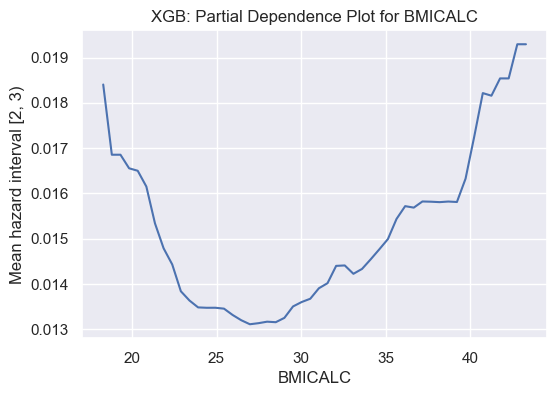

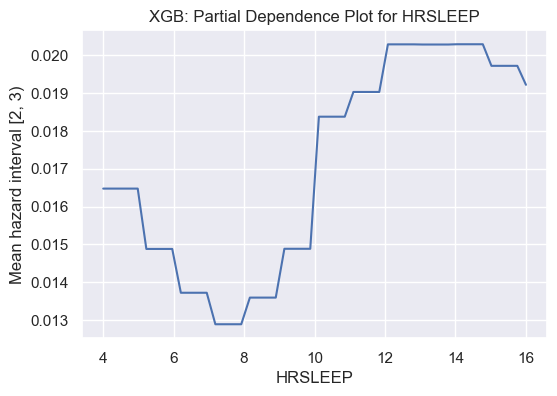

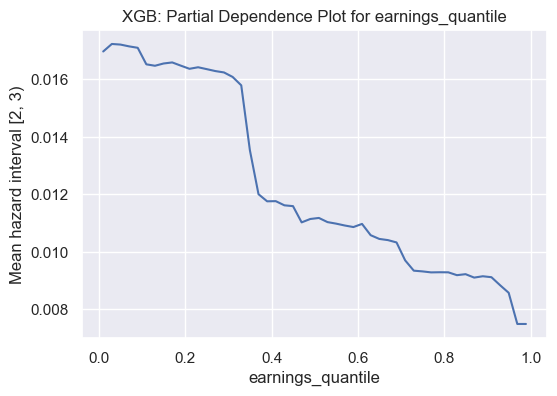

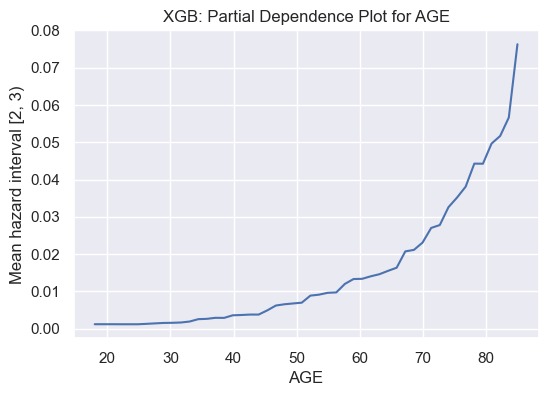

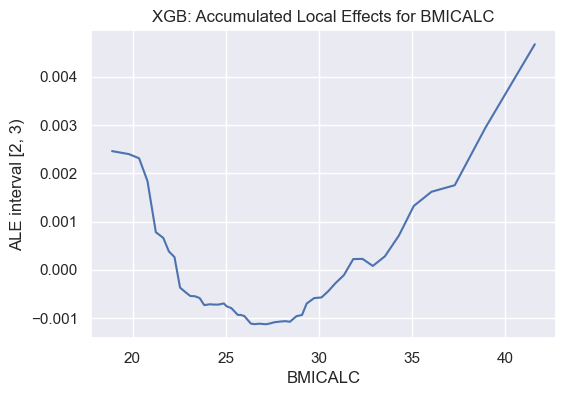

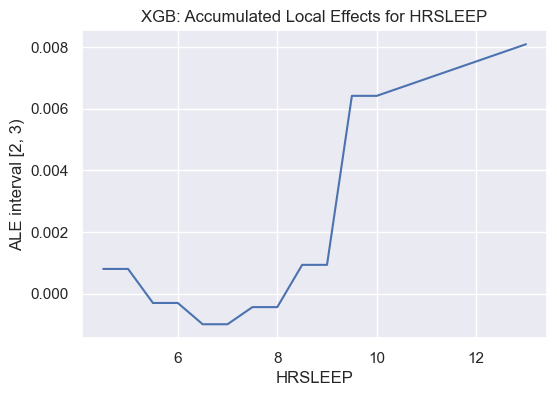

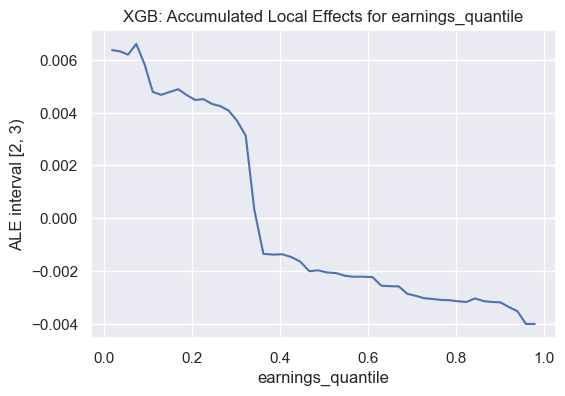

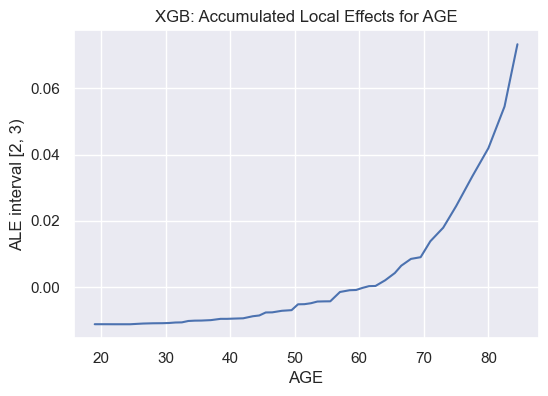

In [246]:
def plot_pdp(model, df, variable, t1, t2):
    x_vals = np.linspace(df[variable].quantile(0.01), df[variable].quantile(0.99), 50)
    y_vals = []
    for val in x_vals:
        df_copy = df.copy()
        df_copy[variable] = val
        pred_surv = np.exp(-model.predict(df_copy)[:,None] * H0[None,:])
        y_vals.append((pred_surv[:,t1] - pred_surv[:,t2]).mean())
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"XGB: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, df, variable, t1, t2):
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = np.exp(-model.predict(df_high)[:,None] * H0[None,:])
        pred_surv_low = np.exp(-model.predict(df_low)[:,None] * H0[None,:])
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"XGB: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(gbst, X_test, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(gbst, X_test, var, 2, 3)

In [36]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])

X_D2 = D2.drop(columns=["T", "event", "mu", "BMI_scaled", "SBP_scaled", "SD_SBP_scaled", "TCL_HDL_RATIO_scaled"])
T_D2 = D2["T"].to_numpy()
E_D2 = D2["event"].to_numpy()
mu_D2 = D2["mu"].to_numpy()

X_D2_train, X_D2_test, T_D2_train, T_D2_test, E_D2_train, E_D2_test, _, mu_D2_test = train_test_split(X_D2, T_D2, E_D2, mu_D2, test_size=0.2, random_state=0)
X_D2_train, X_D2_val, T_D2_train, T_D2_val, E_D2_train, E_D2_val = train_test_split(X_D2_train, T_D2_train, E_D2_train, test_size=0.2, random_state=0)

T_D2_train_mod = T_D2_train.copy()
T_D2_train_mod[E_D2_train == 0] *= -1 # encoding censored events
T_D2_val_mod = T_D2_val.copy()
T_D2_val_mod[E_D2_val == 0] *= -1

y_D2_test = Surv.from_arrays(E_D2_test.astype(bool), T_D2_test)

gbst_D2 = xgb.XGBRegressor(
    objective='survival:cox',
    eval_metric='cox-nloglik',
    learning_rate=0.005,
    n_estimators=5000,
    max_depth=7,
    min_child_weight=50,
    random_state=0,
    early_stopping_rounds=100,
    verbosity=2
)

start_time = time.time()
gbst_D2.fit(X_D2_train, T_D2_train_mod, eval_set=[(X_D2_val, T_D2_val_mod)], verbose=100)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

[0]	validation_0-cox-nloglik:12.21182
[100]	validation_0-cox-nloglik:11.30307
[200]	validation_0-cox-nloglik:11.07437
[300]	validation_0-cox-nloglik:10.97482
[400]	validation_0-cox-nloglik:10.92703
[500]	validation_0-cox-nloglik:10.90219
[600]	validation_0-cox-nloglik:10.88826
[700]	validation_0-cox-nloglik:10.88078
[800]	validation_0-cox-nloglik:10.87676
[900]	validation_0-cox-nloglik:10.87474
[1000]	validation_0-cox-nloglik:10.87383
[1100]	validation_0-cox-nloglik:10.87330
[1200]	validation_0-cox-nloglik:10.87291
[1300]	validation_0-cox-nloglik:10.87286
[1384]	validation_0-cox-nloglik:10.87295
Fitting time: 147.40 seconds


In [49]:
y_D2_test = Surv.from_arrays(E_D2_test.astype(bool), T_D2_test)

risk_scores = gbst_D2.predict(X_D2_test) # these are hazard ratios relative to h_0

c_index = concordance_index_censored(
    y_D2_test["event"], y_D2_test["time"], risk_scores
)[0]
print(f"C-index: {c_index:.4f}")

naf = NelsonAalenFitter()
naf.fit(T_D2_train, event_observed=E_D2_train)
cum_baseline_hazard = naf.cumulative_hazard_
times = cum_baseline_hazard.index.values
H0 = cum_baseline_hazard.values.flatten()
pred_surv = np.exp(-risk_scores[:,None] * H0[None,:])

time_grid = [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9.9]
ibs = integrated_brier_score(y_D2_test, y_D2_test, pred_surv, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (y_D2_test["event"] == True).astype(int)
p_interval = 1 - pred_surv[:, -1]

logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.9069
Integrated Brier Score: 0.0394
Log loss for interval [0, 10): 0.1943


In [50]:
events = E_D2_test.astype(int)
pred = np.minimum(1-1e-5, np.maximum(1e-5, 1 - pred_surv[:, -1]))
mse = np.mean(np.square(np.log(mu_D2_test) - np.log(pred)))
dev = -2*np.sum(events*logit(pred) + np.log(1-pred))
kld = -np.sum(np.log(pred[events==1]))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    0.3606
Logistic deviance:           106967
Kullback-Leibler divergence: 25486


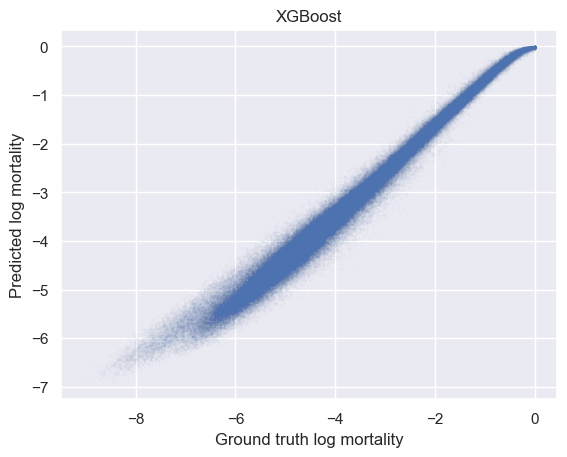

In [51]:
plt.plot(np.log(mu_D2_test), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("XGBoost")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

In [ ]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(gbst_D2, X_D2_test, var, 0, 10)

for var in ["BMI", "SBP", "AGE"]:
    plot_ale(gbst_D2, X_D2_test, var, 0, 10)